In [89]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 2: Load the dataset
data = pd.read_csv('input/train_loan_prediction.csv')  # Replace with correct file path

# Step 3: Preview the dataset
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [90]:
# Identify numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'Loan_ID']

# Step 1: Create an instance of SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Step 2: Fit the imputer on the numerical features
imputer.fit(data[numerical_features])

# Step 3: Transform the numerical features
data[numerical_features] = imputer.transform(data[numerical_features])

# Step 4: Remove outliers using IQR
for feature in numerical_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

# Step 5: Scale numerical features
scaler = StandardScaler()
scaler.fit(data[numerical_features])
data[numerical_features] = scaler.transform(data[numerical_features])

# Display preprocessed numerical features
data[numerical_features].head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1.033966,-0.969937,0.077480,0.0,0.0
1,0.331392,0.119523,0.077480,0.0,0.0
2,-0.547102,-0.969937,-1.488350,0.0,0.0
3,-0.778518,0.733609,-0.124562,0.0,0.0
4,1.117764,-0.969937,0.405800,0.0,0.0


In [91]:
# Identify categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features if col != 'Loan_Status']

# Step 1: Create an instance of SimpleImputer with most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

# Step 2: Fit the imputer on the categorical features
imputer.fit(data[categorical_features])

# Step 3: Transform the categorical features
data[categorical_features] = imputer.transform(data[categorical_features])

# Step 4: Handle rare categories
threshold = 10
for feature in categorical_features:
    rare_categories = data[feature].value_counts()[data[feature].value_counts() < threshold].index
    data[feature] = data[feature].replace(rare_categories, 'Other')

# Step 5: Encode categorical features using Ordinal Encoding
encoder = OrdinalEncoder()
encoder.fit(data[categorical_features])
data[categorical_features] = encoder.transform(data[categorical_features])

# Display preprocessed categorical features
data[categorical_features].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,2.0
3,0.0,1.0,1.0,0.0,1.0,0.0,2.0
4,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [92]:
# Define features and target
X = data[numerical_features + categorical_features]
y = data['Loan_Status']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# Train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

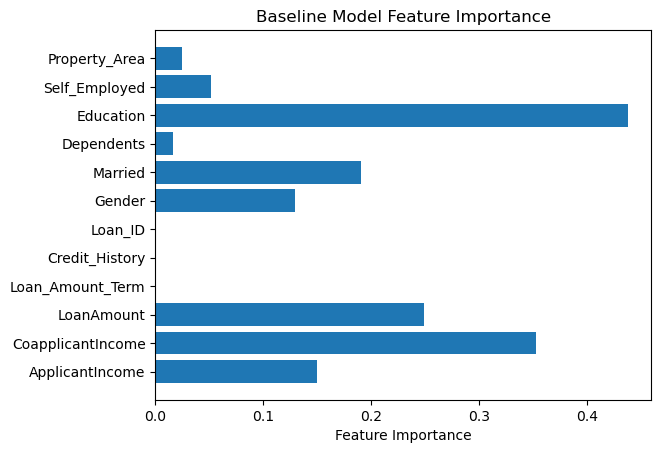

In [94]:
# Predict on the test set
y_test_pred = logistic_model.predict(X_test)

# Calculate metrics
baseline_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred, pos_label='Y'),  # Specify the positive class
    "Recall": recall_score(y_test, y_test_pred, pos_label='Y'),
    "F1 Score": f1_score(y_test, y_test_pred, pos_label='Y'),
    "ROC-AUC": roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1]),
}
baseline_metrics

# Display feature importance
feature_importance = abs(logistic_model.coef_[0])
feature_names = X.columns
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance")
plt.title("Baseline Model Feature Importance")
plt.show()

In [95]:
# Calculate correlation matrix
correlation_matrix = X.corr().abs()

# Select features with correlation below the threshold (excluding self-correlation)
correlation_threshold = 0.8  # Typical threshold for feature removal
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify features with high correlation
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Remove highly correlated features
filtered_features = [col for col in X.columns if col not in high_corr_features]

# Display filtered features
filtered_features

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [96]:
# Train model with filtered features
X_train_filtered = X_train[filtered_features]
X_test_filtered = X_test[filtered_features]
logistic_model_filtered = LogisticRegression()
logistic_model_filtered.fit(X_train_filtered, y_train)

LogisticRegression()

In [97]:
# Convert target variable to numeric values
y_train = y_train.map({'Y': 1, 'N': 0})
y_test = y_test.map({'Y': 1, 'N': 0})

# Predict on the test set with filtered features
y_test_pred_filtered = logistic_model_filtered.predict(X_test_filtered)

# Convert predictions to numeric values
y_test_pred_filtered = pd.Series(y_test_pred_filtered).map({'Y': 1, 'N': 0})

# Calculate metrics for filtered features model
metrics_filtered = {
    "Accuracy": accuracy_score(y_test, y_test_pred_filtered),
    "Precision": precision_score(y_test, y_test_pred_filtered),
    "Recall": recall_score(y_test, y_test_pred_filtered),
    "F1 Score": f1_score(y_test, y_test_pred_filtered),
    "ROC-AUC": roc_auc_score(y_test, logistic_model_filtered.predict_proba(X_test_filtered)[:, 1]),
}
metrics_filtered

{'Accuracy': 0.8051948051948052,
 'Precision': 0.8051948051948052,
 'Recall': 1.0,
 'F1 Score': 0.8920863309352518,
 'ROC-AUC': 0.5774193548387097}

In [98]:
# Step 1: Select only numerical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Step 2: Drop columns with constant values (zero variance)
X_train_filtered = X_train[numeric_cols].loc[:, X_train[numeric_cols].nunique() > 1]

# Step 3: Ensure no missing values
X_train_filtered = X_train_filtered.dropna()

# Step 4: Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_filtered.values, i) for i in range(X_train_filtered.shape[1])]

# Display VIF
vif_data

,Feature,VIF
0,ApplicantIncome,1.727693
1,CoapplicantIncome,1.528243
2,LoanAmount,1.667344
3,Gender,4.312421
4,Married,3.766197
5,Dependents,1.820159
6,Education,1.297501
7,Self_Employed,1.170021
8,Property_Area,2.238869


In [99]:
# Define VIF threshold
vif_threshold = 5
reduced_features = vif_data[vif_data["VIF"] < vif_threshold]["Feature"].tolist()

# Train and evaluate model with reduced features
X_train_reduced = X_train[reduced_features]
X_test_reduced = X_test[reduced_features]
logistic_model_reduced = LogisticRegression()
logistic_model_reduced.fit(X_train_reduced, y_train)

# Predict on the test set with reduced features
y_test_pred_reduced = logistic_model_reduced.predict(X_test_reduced)

# Calculate metrics for reduced features model
metrics_reduced = {
    "Accuracy": accuracy_score(y_test, y_test_pred_reduced),
    "Precision": precision_score(y_test, y_test_pred_reduced),
    "Recall": recall_score(y_test, y_test_pred_reduced),
    "F1 Score": f1_score(y_test, y_test_pred_reduced),
    "ROC-AUC": roc_auc_score(y_test, logistic_model_reduced.predict_proba(X_test_reduced)[:, 1]),
}
metrics_reduced

{'Accuracy': 0.8051948051948052,
 'Precision': 0.8051948051948052,
 'Recall': 1.0,
 'F1 Score': 0.8920863309352518,
 'ROC-AUC': 0.5774193548387097}

In [100]:
# Apply RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
selected_features_rfe

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_ID',
       'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')

In [101]:
# Train and evaluate model with RFE-selected features
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]
logistic_model_rfe = LogisticRegression()
logistic_model_rfe.fit(X_train_rfe, y_train)

# Predict on the test set with RFE-selected features
y_test_pred_rfe = logistic_model_rfe.predict(X_test_rfe)

# Calculate metrics for RFE model
metrics_rfe = {
    "Accuracy": accuracy_score(y_test, y_test_pred_rfe),
    "Precision": precision_score(y_test, y_test_pred_rfe),
    "Recall": recall_score(y_test, y_test_pred_rfe),
    "F1 Score": f1_score(y_test, y_test_pred_rfe),
    "ROC-AUC": roc_auc_score(y_test, logistic_model_rfe.predict_proba(X_test_rfe)[:, 1]),
}
metrics_rfe

{'Accuracy': 0.8051948051948052,
 'Precision': 0.8051948051948052,
 'Recall': 1.0,
 'F1 Score': 0.8920863309352518,
 'ROC-AUC': 0.5774193548387097}

In [102]:
# Apply Lasso Regression
lasso = LassoCV(cv=5, alphas=[0.01, 0.005, 0.001, 0.0005, 0.0001])
lasso.fit(X_train, y_train)

# Select non-zero coefficient features
selected_features_lasso = X_train.columns[lasso.coef_ != 0]
selected_features_lasso

Index(['CoapplicantIncome', 'LoanAmount', 'Education'], dtype='object')

In [103]:
# Train and evaluate model with Lasso-selected features
X_train_lasso = X_train[selected_features_lasso]
X_test_lasso = X_test[selected_features_lasso]
logistic_model_lasso = LogisticRegression()
logistic_model_lasso.fit(X_train_lasso, y_train)

# Predict on the test set with Lasso-selected features
y_test_pred_lasso = logistic_model_lasso.predict(X_test_lasso)

# Calculate metrics for Lasso model
metrics_lasso = {
    "Accuracy": accuracy_score(y_test, y_test_pred_lasso),
    "Precision": precision_score(y_test, y_test_pred_lasso),
    "Recall": recall_score(y_test, y_test_pred_lasso),
    "F1 Score": f1_score(y_test, y_test_pred_lasso),
    "ROC-AUC": roc_auc_score(y_test, logistic_model_lasso.predict_proba(X_test_lasso)[:, 1]),
}
metrics_lasso

{'Accuracy': 0.8051948051948052,
 'Precision': 0.8051948051948052,
 'Recall': 1.0,
 'F1 Score': 0.8920863309352518,
 'ROC-AUC': 0.5881720430107527}

In [104]:
# Compare model performance across all feature selection methods
comparison_metrics = pd.DataFrame({
    "Baseline Model": baseline_metrics,
    "Filter-Based Model": metrics_filtered,
    "VIF-Based Model": metrics_reduced,
    "RFE Model": metrics_rfe,
    "Lasso Model": metrics_lasso
}).T

# Display the comparison metrics
comparison_metrics

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Baseline Model,0.805195,0.805195,1.0,0.892086,0.577419
Filter-Based Model,0.805195,0.805195,1.0,0.892086,0.577419
VIF-Based Model,0.805195,0.805195,1.0,0.892086,0.577419
RFE Model,0.805195,0.805195,1.0,0.892086,0.577419
Lasso Model,0.805195,0.805195,1.0,0.892086,0.588172


In [105]:
# Identify the best feature selection method
best_method = comparison_metrics.sort_values(by=["Accuracy", "ROC-AUC"], ascending=False).index[0]
best_method

'Lasso Model'

In [106]:
# Train the final model using the best feature selection method
if best_method == "Filter-Based Model":
    X_train_final, X_test_final = X_train_filtered, X_test_filtered
elif best_method == "VIF-Based Model":
    X_train_final, X_test_final = X_train_reduced, X_test_reduced
elif best_method == "RFE Model":
    X_train_final, X_test_final = X_train_rfe, X_test_rfe
else:
    X_train_final, X_test_final = X_train_lasso, X_test_lasso

# Train final logistic regression model
final_model = LogisticRegression()
final_model.fit(X_train_final, y_train)

# Predict on the final test set
y_test_pred_final = final_model.predict(X_test_final)

# Calculate final model metrics
final_model_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_final),
    "Precision": precision_score(y_test, y_test_pred_final),
    "Recall": recall_score(y_test, y_test_pred_final),
    "F1 Score": f1_score(y_test, y_test_pred_final),
    "ROC-AUC": roc_auc_score(y_test, final_model.predict_proba(X_test_final)[:, 1]),
}
final_model_metrics

{'Accuracy': 0.8051948051948052,
 'Precision': 0.8051948051948052,
 'Recall': 1.0,
 'F1 Score': 0.8920863309352518,
 'ROC-AUC': 0.5881720430107527}

Final Model Performance Based on Best Feature Selection Method:


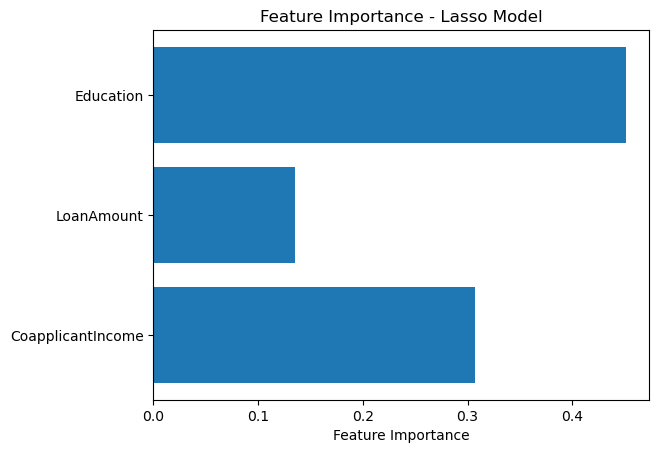

In [107]:
# Print final model performance
print("Final Model Performance Based on Best Feature Selection Method:")
final_model_metrics

# Display feature importance for the final model
feature_importance_final = abs(final_model.coef_[0])
feature_names_final = X_train_final.columns
plt.barh(feature_names_final, feature_importance_final)
plt.xlabel("Feature Importance")
plt.title(f"Feature Importance - {best_method}")
plt.show()